# RNN text sentiment analyzer

In [1]:
import torch
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import torch.nn as nn
import tqdm
from torch.nn.utils.rnn import pad_sequence

from utils.text_datasets import get_poem_sentiment_dataset
from utils.metrics import display_clasification_metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data

In [3]:
BATCH_SIZE = 128

In [4]:
corpus = api.load("text8")
gensim_model = Word2Vec(corpus)
tokenizer = gensim_model.wv.key_to_index
emb_weights = torch.FloatTensor(gensim_model.wv.vectors)


def tokenize_function(examples):
    review_tokenized = []
    all_parsed = 0
    unknows = 0
    for word in examples.split():
        all_parsed += 1
        try:
            review_tokenized.append(tokenizer[word.lower()])
        except:
            unknows += 1
    return review_tokenized

In [5]:
def pad_collate(batch):
    xx, yy = zip(*batch)
    x_lens = [len(x) - 1 for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy, x_lens

## Poem Dataset

In [6]:
train_dataset, validation_dataset, test_dataset = get_poem_sentiment_dataset(
    tokenize_function
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

# Model

In [7]:
class LstmSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items
        x = self.fc(out)
        return x, hidden

In [6]:
class GruSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.gru(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items
        x = self.fc(out)
        return x, hidden

# Training

In [8]:
model = LstmSentimentClasifier(100, 64, 2, 4, emb_weights, bidirectional=True).to(
    device
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
weights = torch.tensor([1.5, 1.5, 0.8, 2.0]).to(device)
loss_fun = nn.CrossEntropyLoss(weight=weights)
model.train()

EPOCHS = 25

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, len_x, (hidden, state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    progress_bar.set_postfix({"Train loss": losses / batches})

Epoch: 100%|██████████| 25/25 [00:01<00:00, 17.45it/s, Train loss=0.35] 


## Measure accuracy

F1 Score 0.31715911020546783
Accuracy 0.6285714285714286
Recall 0.30896935433212186


/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


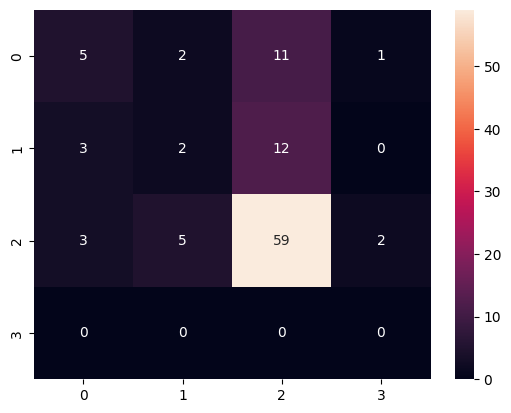

In [9]:
total_preds = torch.tensor([]).to(device)
total_targets = torch.tensor([]).to(device)

model.eval()

for x, targets, len_x in validation_loader:
    x = x.to(device)
    targets = targets.to(device)
    hidden, state = model.init_hidden(x.size(0))
    hidden, state = hidden.to(device), state.to(device)
    preds, _ = model(x, len_x, (hidden, state))
    preds = preds.squeeze(1)
    total_preds = torch.cat((total_preds, preds.argmax(1)), 0)
    total_targets = torch.cat((total_targets, targets), 0)

display_clasification_metrics(total_preds.cpu(), total_targets.cpu())